# CONSTRUCTION OF FX VOL SURFACE - PART III

In this notebook I show how you can calibrate to the FX Vol Surface to ATM, 25D and 10D at multiple expiry dates and analyse different volatility interpolation methods.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from financepy.finutils import *
from financepy.models.FinModelBlackScholes import *
from financepy.products.fx.FinFXOption import *
from financepy.market.curves.FinDiscountCurveFlat import FinDiscountCurveFlat
from financepy.market.volatility.FinFXVolSurfacePlus import *

####################################################################
# FINANCEPY BETA Version 0.191 - This build:  06 Jan 2021 at 21:06 #
#      This software is distributed FREE & WITHOUT ANY WARRANTY    #
# For info and disclaimer - https://github.com/domokane/FinancePy  #
#      Send any bug reports or comments to quant@financepy.com     #
####################################################################



## Load the Volatility Market Quotes

In [4]:
valueDate = FinDate(10, 4, 2020)

In [5]:
forName = "EUR"
domName = "USD"
forCCRate = 0.03460  # EUR
domCCRate = 0.02940  # USD

We need to set up the option details - what you would find in the Term Sheet.

In [6]:
domDiscountCurve = FinDiscountCurveFlat(valueDate, domCCRate)
forDiscountCurve = FinDiscountCurveFlat(valueDate, forCCRate)

In [7]:
currencyPair = forName + domName
spotFXRate = 1.3465        

I now load the option tenor, the ATM vol and the market strangle and risk-reversal quotes.

In [8]:
tenors = ['1M', '2M', '3M', '6M', '1Y', '2Y']
atmVols = [21.00, 21.00, 20.750, 19.400, 18.250, 17.677]
ms25DeltaVols = [0.65, 0.75, 0.85, 0.90, 0.95, 0.85]
rr25DeltaVols = [-0.20, -0.25, -0.30, -0.50, -0.60, -0.562]
ms10DeltaVols = [2.433, 2.83, 3.228, 3.485, 3.806, 3.208]
rr10DeltaVols = [-1.258, -1.297, -1.332, -1.408, -1.359, -1.208]

We need to set some parameters for the vol surface.

In [11]:
notionalCurrency = forName
atmMethod = FinFXATMMethod.FWD_DELTA_NEUTRAL
deltaMethod = FinFXDeltaMethod.SPOT_DELTA
alpha = 0.5

In [19]:
fxVolSurfaceClark = FinFXVolSurfacePlus(valueDate, spotFXRate, currencyPair, notionalCurrency,
                                        domDiscountCurve, forDiscountCurve,
                                        tenors, atmVols, 
                                        ms25DeltaVols, rr25DeltaVols, 
                                        ms10DeltaVols, rr25DeltaVols,
                                        alpha,
                                        atmMethod, deltaMethod, 
                                        FinVolFunctionTypes.CLARK5)

In [20]:
fxVolSurfaceSABR = FinFXVolSurfacePlus(valueDate, spotFXRate, currencyPair, notionalCurrency,
                                       domDiscountCurve, forDiscountCurve,
                                       tenors, atmVols, 
                                       ms25DeltaVols, rr25DeltaVols, 
                                       ms10DeltaVols, rr25DeltaVols,
                                       alpha,
                                       atmMethod, deltaMethod,
                                       FinVolFunctionTypes.SABR)

In [21]:
fxVolSurfaceBBG = FinFXVolSurfacePlus(valueDate, spotFXRate, currencyPair, notionalCurrency,
                                      domDiscountCurve, forDiscountCurve,
                                      tenors, atmVols, 
                                      ms25DeltaVols, rr25DeltaVols, 
                                      ms10DeltaVols, rr25DeltaVols,
                                      alpha,
                                      atmMethod, deltaMethod,
                                      FinVolFunctionTypes.BBG)

We can examine the calibration

## Checking the Basics - Does it Recovery ATM Volatility

In [22]:
expiryDates = valueDate.addTenor(tenors)

In [23]:
fxVolSurfaceClark._F0T

array([1.3459262 , 1.34533354, 1.34476024, 1.34300365, 1.33953024,
       1.33258276])

In [24]:
for i in range(0, len(expiryDates)):
    fwd = fxVolSurfaceClark._F0T[i]
    kATM = fxVolSurfaceClark._K_ATM[i]
    vATM = fxVolSurfaceClark._atmVols[i]
    volClark = fxVolSurfaceClark.volatility(kATM, expiryDates[i])
    print("fwd", fwd, "KATM", kATM, "volATM", vATM*100, "volInterp", volClark*100)

fwd 1.3459262042602333 KATM 1.3483676767457906 volATM 21.0 volInterp 20.9999295607186
fwd 1.3453335388728314 KATM 1.350300330973612 volATM 21.0 volInterp 20.999963993080883
fwd 1.344760240207283 KATM 1.3519973574277078 volATM 20.75 volInterp 20.74994475298844
fwd 1.3430036472282152 KATM 1.3557345507916598 volATM 19.4 volInterp 19.399943877082013
fwd 1.339530242682178 KATM 1.3620243862979695 volATM 18.25 volInterp 18.250061824832727
fwd 1.3325827645184334 KATM 1.3748802277559837 volATM 17.677 volInterp 17.677103868368132


Fit is good but not perfect.

## Volatility Smile Analysis - Different Volatility Function Types

In [25]:
strikes = np.linspace(0.5, 2.5, 1000)

In [26]:
expiryDate = valueDate.addTenor("1Y")

In [27]:
volsClark = []
volsSABR = []
volsBBG = []

for k in strikes:
    volClark = fxVolSurfaceClark.volatility(k, expiryDate)
    volSABR = fxVolSurfaceSABR.volatility(k, expiryDate)
    volBBG = fxVolSurfaceBBG.volatility(k, expiryDate)
    volsClark.append(volClark*100.0)    
    volsSABR.append(volSABR*100.0)    
    volsBBG.append(volBBG*100.0)    

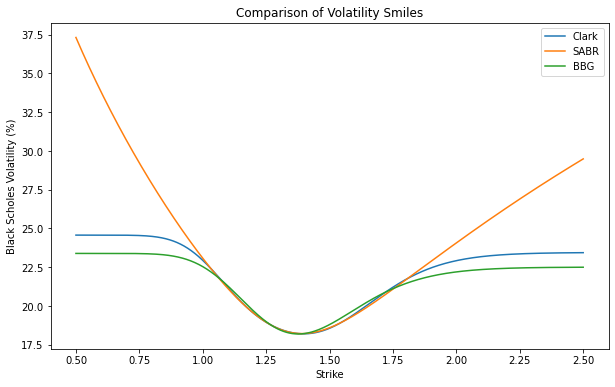

In [28]:
plt.figure(figsize=(10,6))
plt.plot(strikes, volsClark, label="Clark")
plt.plot(strikes, volsSABR, label="SABR")
plt.plot(strikes, volsBBG, label="BBG")
plt.xlabel("Strike")
plt.ylabel("Black Scholes Volatility (%)")
plt.title("Comparison of Volatility Smiles")
plt.legend();

## Implied FX Rate Probability Density Functions

In [29]:
lower = 0.50
upper = 2.25
dbnClark = fxVolSurfaceClark.impliedDbns(lower, upper, 1000)
dbnSABR = fxVolSurfaceSABR.impliedDbns(lower, upper, 1000)
dbnBBG = fxVolSurfaceBBG.impliedDbns(lower, upper, 1000)

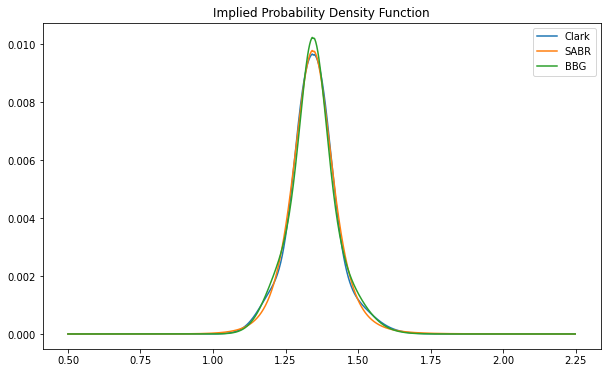

In [30]:
plt.figure(figsize=(10,6))
plt.plot(dbnClark[0]._x, dbnClark[0]._densitydx, label="Clark")
plt.plot(dbnSABR[0]._x, dbnSABR[0]._densitydx, label="SABR")
plt.plot(dbnBBG[0]._x, dbnBBG[0]._densitydx, label="BBG")
plt.title("Implied Probability Density Function")
plt.legend();

## Expiry Date Interpolation

We only have one expiry date. The volatility is therefore assumed to be flat at the level of this expiry date.

In [31]:
k = 1.35

In [32]:
years = np.linspace(0.0, 3.0, 301)

In [33]:
expiryDates = valueDate.addYears(years)

In [34]:
volsClark = []

for expiryDate in expiryDates:
    volClark = fxVolSurfaceClark.volatility(k, expiryDate)
    volsClark.append(volClark*100.0)    

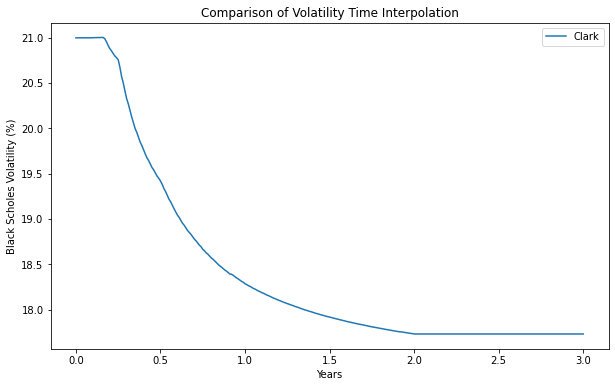

In [35]:
plt.figure(figsize=(10,6))
plt.plot(years, volsClark, label="Clark")
plt.xlabel("Years")
plt.ylabel("Black Scholes Volatility (%)")
plt.title("Comparison of Volatility Time Interpolation")
plt.legend();

Copyright (c) 2020, Dominic O'Kane 